# Calculate Grounding Zone Widths

For a given region, group grounding lines together and create a polygon, then use the boundary of that polygon to get the width of the grounding zone.

## NOTES
Making buffer for lines individually (instead of converting to MultiLineString first) and then creating multi polygon might be faster than current way.

In [112]:
import os
import random
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
import pyproj
from shapely.geometry import Point,MultiPoint,LineString,MultiLineString,Polygon,MultiPolygon
from shapely import ops
from descartes import PolygonPatch

In [25]:
%matplotlib inline

In [2]:
base_dir = os.path.expanduser('~')
#-- specify GL file
file_6d = os.path.join(base_dir,'GL_learning_data','6d_results','AllTracks_6d_GL.shp')

In [84]:
gdf = gpd.read_file(file_6d)

Read boundary of ice shelf in order to get intersection with lines:

In [85]:
basins = gpd.read_file(os.path.join(base_dir,'data.dir','basin.dir','Gates_Basin_v1.7','Basins_v2.4.shp'))

In [86]:
basins

,NAME,Regions,Subregion2,Subregion,SLE,geometry
0,LarsenE,Peninsula,LarsenE_Ice_Shelf,"I""-J",0.77,"POLYGON ((-1604213.024 911528.811, -1603107.44..."
1,Coats_Coast,East,Coats_Coast,K-A,4.94,"POLYGON ((-681761.563 1361890.885, -680167.251..."
2,Academy,East,Filchner_Ice_Shelf,"J""-K",247.33,"POLYGON ((-650545.636 590416.431, -644265.131 ..."
3,Stancomb_Wills,East,Stancomb_Wills_Ice_Shelf,K-A,46.14,"POLYGON ((-549906.633 1305863.952, -572323.238..."
4,Riiser-Larsen,East,Riiser-Larsen_Ice_Shelf,K-A,19.00,"POLYGON ((-418449.622 1964493.872, -417441.371..."
...,...,...,...,...,...,...
196,Enderby_Land2,East,Enderby_Land_2,A'-B,0.00,"POLYGON ((2120087.293 1409593.226, 2120761.769..."
197,David,East,Drygalski_Ice_Shelf,D'-E,117.99,"POLYGON ((1362451.207 -906394.029, 1362282.310..."
198,Islands,Islands,Islands,Islands,8.76,"MULTIPOLYGON (((-2630075.000 1586825.000, -262..."
199,Islands,Islands,Islands,Islands,0.00,"POLYGON ((-1453517.353 311789.988, -1453035.86..."


In [87]:
idx = basins.index[basins['NAME']=='Getz']

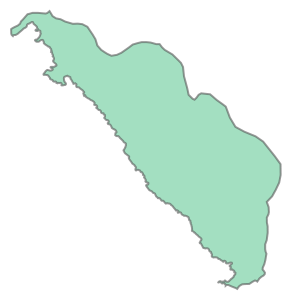

In [88]:
#-- get polygon
poly = basins['geometry'][idx[0]]
poly

In [89]:
#-- add a 5km buffer to finding the corresponding GLs
region_poly = poly.buffer(5e3)

Go through lines and find those that intersect the region:

In [123]:
lines = []
dates = []
for i in range(len(gdf)):
    #-- extract geometry to see if it's in region of interest
    ll = gdf['geometry'][i]
    if ll.intersects(region_poly):
        lines.append(ll)
        dates.append(gdf['FILENAME'][i].split("_")[2])

In [91]:
#-- merge all lines into linestring
lm = ops.linemerge(lines)

In [83]:
#-- read widths
WIDTH_FILE = os.path.join(base_dir,'GL_learning_data',\
	'6d_results','GZ_Getz_widths_400m.shp')
df_w = gpd.read_file(WIDTH_FILE)    

In [92]:
#-- get width lines
ws = []
for i in range(len(df_w)):
    ws.append(df_w['geometry'][i])
widths = MultiLineString(ws)

In [117]:
for _ in range(20):
    i = random.randrange(0,len(widths))
    pt0 = widths[i].interpolate(0,normalized=True)
    pt1 = widths[i].interpolate(1,normalized=True)
    pt_int = widths[i].intersection(lm)
    x1,y1 = pt_int[-1].coords.xy
    xx1,yy1 = pt0.coords.xy
    x2,y2 = pt_int[0].coords.xy
    xx2,yy2 = pt1.coords.xy
    print(x1[0]-xx1[0],y1[0]-yy1[0],x2[0]-xx2[0],y2[0]-yy2[0])

-0.09962696069851518 0.009380881441757083 0.09965759376063943 -0.00938376598060131
-0.010601837886497378 0.11208211735356599 0.010477564996108413 -0.11076831223908812
-0.014966372167691588 -0.11492418916895986 0.016618878347799182 0.12761350022628903
-0.10248263133689761 0.013347794068977237 0.11429087887518108 -0.01488575292751193
-0.09408843400888145 -0.041665064985863864 0.09536979906260967 0.04223249037750065
-0.01697298279032111 0.10333855636417866 0.01758238347247243 -0.10704884072765708
-0.0875586592592299 0.06117592356167734 0.08241712534800172 -0.057583610876463354
-0.04913579183630645 -0.08780831738840789 0.048900270368903875 0.08738742768764496
-0.032365214079618454 -0.13964133895933628 0.02310266299173236 0.0996775982202962
-0.09848960349336267 -0.018061092006973922 0.09872688422910869 0.018104604678228498
-0.07637914805673063 -0.08794631122145802 0.06716728792525828 0.07733937015291303
-0.030108352191746235 0.09678260225336999 0.030275954864919186 -0.09732135676313192
-0.0

So `pt0` is the last intersection (`pt_int[-1]`) and `pt1` is the first intersection (`pt_int[0]`).
Note they don't match exactly because of the 10cm buffer used in creating the GZ polygon.

Now for each point, loop through elements of `ml` to see which LineStrings intersect with the first and last points to get their dates.

In [124]:
for _ in range(20):
    i = random.randrange(0,len(widths))
    pt0 = widths[i].interpolate(0,normalized=True)
    pt1 = widths[i].interpolate(1,normalized=True)
    for c,l in enumerate(lines):
        if l.distance(pt1) < 0.2:
            print("Found first date for point {0:d}: {1}".format(_,dates[c]))
        elif l.distance(pt0) < 0.2:
            print("Found second line for point {0:d}: {1}".format(_,dates[c]))

Found first date for point 0: 181120-181126-181126-181202
Found second line for point 0: 181114-181120-181120-181126
Found first date for point 1: 180727-180802-180808-180814
Found second line for point 1: 180826-180901-180907-180913
Found second line for point 2: 180115-180121-180121-180127
Found first date for point 2: 180810-180816-180822-180828
Found second line for point 3: 180715-180721-180727-180802
Found first date for point 3: 180913-180919-180925-181001
Found second line for point 4: 180418-180424-180424-180430
Found first date for point 4: 180915-180921-180921-180927
Found first date for point 5: 180406-180412-180418-180424
Found second line for point 5: 180605-180611-180617-180623
Found second line for point 6: 180605-180611-180611-180617
Found first date for point 6: 180605-180611-180617-180623
Found second line for point 7: 181124-181130-181130-181206
Found first date for point 7: 180116-180122-180128-180203
Found first date for point 8: 180909-180915-180921-180927
Found 

In [104]:
pt_int = widths[0].intersection(lm)

In [110]:
pt_int[-1].coords.xy

(array('d', [-1572472.7396068515]), array('d', [-736514.0770206411]))

In [111]:
pt0.coords.xy

(array('d', [-1572472.719412035]), array('d', [-736514.1768916575]))

** NOTE ** Creating a polygon out of GLs takes a long time, so if the GZ polygon has already been created, just load it in instead.

In [12]:
#-- convert to polygon with small buffer (10cm)
ep = lm.buffer(1e-1)
#-- get the boundary of the polygon containing all lines to make new polygon of just the envelope
err_poly = []
for ip in ep:
    x,y = ip.exterior.coords.xy
    err_poly.append(Polygon(zip(x,y)))
#-- save the error polygon
#-- first make DataFrame
df = {'REGION':[],'center_x':[],'center_y':[]}
out_geo = []
for p in err_poly:
    width = p.area/(p.length/2)
    if width > 1:
        df['REGION'].append('Getz')
        x,y = p.centroid.coords.xy
        df['center_x'].append(x[0])
        df['center_y'].append(y[0])
        out_geo.append(p)
out_gdf = gpd.GeoDataFrame(df,geometry=out_geo,crs=gdf.crs)
outfile = os.path.join(base_dir,'GL_learning_data','6d_results','GZ_Getz.shp')
out_gdf.to_file(outfile,driver='ESRI Shapefile')

In [22]:
#-- also save GZ widths to file
fid = open(outfile.replace('.shp','.csv'),'w')
fid.write('Center_X,Center_Y,WIDTH(m,LENGTH(m),AREA(m2)\n')
for i in range(len(out_gdf)):
    fid.write('{0:.2f},{1:.2f},{2:.1f},{3:.1f},{4:.1f}\n'.format(
        out_gdf['center_x'][i],
        out_gdf['center_y'][i],
        out_gdf['geometry'][i].area/out_gdf['geometry'][i].length,
        out_gdf['geometry'][i].length,
        out_gdf['geometry'][i].area
    ))
fid.close()

In [3]:
gz_file = os.path.join(base_dir,'GL_learning_data','6d_results','GZ_Getz.shp')
gz_df = gpd.read_file(gz_file)
gz_poly = []
for i in range(len(gz_df)):
    gz_poly.append(gz_df['geometry'][i])
gz_poly = MultiPolygon(gz_poly)

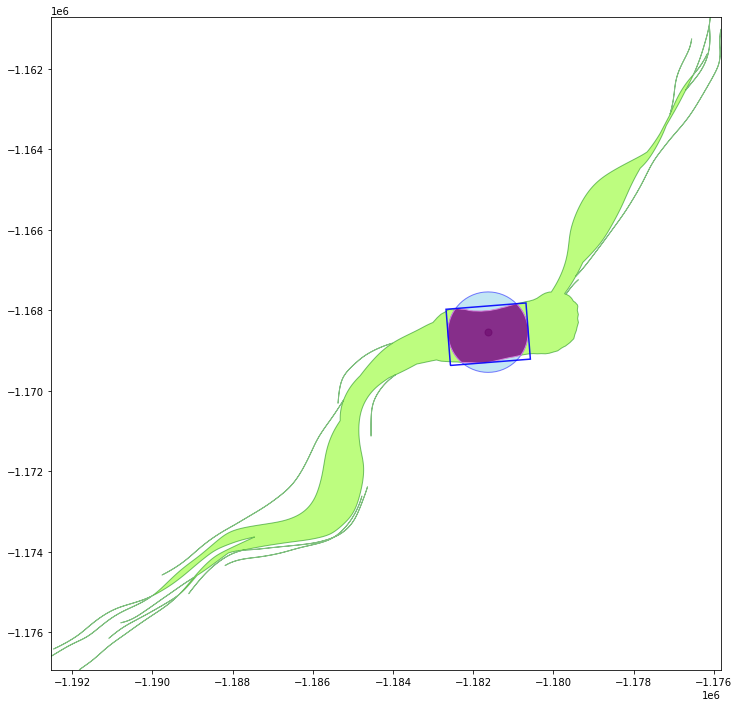

In [34]:
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111)
pp = PolygonPatch(gz_poly[1],alpha=0.5,fc='lawngreen',ec='green',zorder=1)
ax.add_patch(pp)

x0,y0 = -1.18163e6,-1.16854e6
ax.scatter(x0,y0,s=50,color='black',alpha=0.5,zorder=3)
p0 = Point(x0,y0).buffer(1e3)
tpp = PolygonPatch(p0,alpha=0.5,fc='skyblue',ec='blue',zorder=2)
ax.add_patch(tpp)

int_poly = gz_poly[1].intersection(p0)
pp = PolygonPatch(int_poly,alpha=0.8,fc='purple',ec='violet',zorder=4)
ax.add_patch(pp)

bb = int_poly.minimum_rotated_rectangle
pp = PolygonPatch(bb,alpha=0.9,fc=None,ec='blue',fill=False,linewidth=1.5,zorder=5)
ax.add_patch(pp)

x,y = gz_poly[1].exterior.coords.xy
ax.set_xlim([np.min(x),np.max(x)])
ax.set_ylim([np.min(y),np.max(y)])
plt.show()

In [40]:
x, y = bb.exterior.coords.xy
el = [Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2]))]
el

[1999.613739483217, 1399.4155234524128]

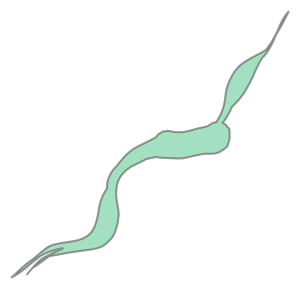

In [38]:
gz_poly[1].buffer(-10)

In [24]:
print('area: ',out_geo[0].area)
print('Length: ',out_geo[0].length)
print('Width: ',out_geo[0].area/out_geo[0].length)

area:  73697762.17590474
Length:  117256.65723412731
Width:  628.5166566598588


# Approach 2: velocity-based intersection width

Use the velocity vector at a given coordinate to get the downstream direction, make a line segment, and get the intersection point of the line with the GL MultiLines.

In [64]:
#-- read velocity file
vel_file = os.path.join(base_dir,'data.dir','basin.dir','ANT_velocity.dir','antarctica_ice_velocity_450m_v2.nc')

In [65]:
vel_fid = nc.Dataset(vel_file,'r')

In [66]:
x = vel_fid['x'][:]
y = vel_fid['y'][:]
vx = vel_fid['VX'][:]
vy = vel_fid['VY'][:]

In [67]:
#-- also read lat and lon
vel_lat = vel_fid['lat'][:]
vel_lon = vel_fid['lon'][:]

In [68]:
vel_fid.close()

For a given coordinate, get the flow angle and then the intersecting line

In [46]:
ii = np.argmin(np.abs(x - (-1512947)))
jj = np.argmin(np.abs(y - (-799396)))

In [47]:
ang = np.arctan(vy[jj,ii]/vx[jj,ii])
print("Angle: {0:.1f}".format(np.degrees(ang)))

Angle: -23.4


Now constuct a line of a given length, centered at the chosen coordinates, with the angle above

In [48]:
d = 6000
dx,dy = d*np.cos(ang),d*np.sin(ang)
dx,dy

(5505.3040981292725, -2385.7128024101257)

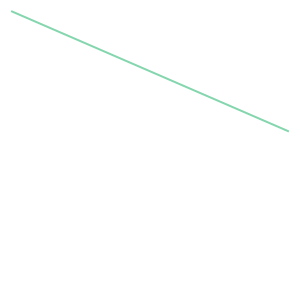

In [49]:
transect = LineString([[x[ii]-dx,y[jj]-dy],[x[ii],y[jj]],[x[ii]+dx,y[jj]+dy]])
transect

Now get the intersection of the transect with the MultiLine representing GLs

In [50]:
pts_ll = transect.intersection(gz_poly)

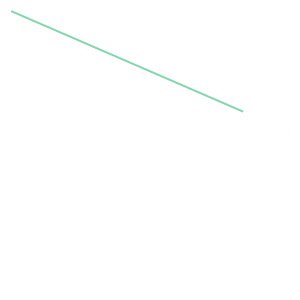

In [62]:
pts_ll

In [63]:
pts_ll[0].coords.xy

(array('d', [-1513838.271894829, -1513000.0, -1512770.087015214]), array('d', [-799186.7365079662, -799550.0, -799649.6323439119]))

In [41]:
#-- construct a line from the intersection points to get the length
ll_int = LineString(pts_ll)
ll_int.length

1393.657206291748

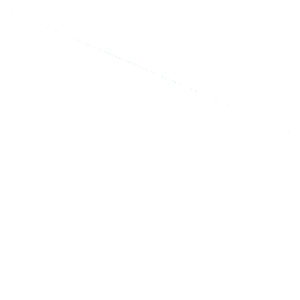

In [36]:
pts = transect.intersection(ep)
pts

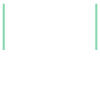

In [78]:
l1 = LineString([[0,0],[0,1]])
l2 = LineString([[2,0],[2,1]])
ll = MultiLineString([l1,l2])
ll

In [80]:
pt = Point(0.9,0.5)
ll.distance(pt)

0.9